---
title: Deforestation Monitoring using Sentinel 2 and xarray
subtitle: Streamlining Cloud-Based Processing with EOPF and Xarray
authors:
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
  - name: Tina Erica Odaka
    orcid: 0000-0002-1500-0156
    github: tinaok
    affiliations:
      - id: IFREMER
        institution: French Research Institute for Exploitation of the Sea
        ror: 044jxhp58
reviewers:
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-03-04
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: earth and related environmental sciences
releaseDate: 2025-03-04
datePublished: 2025-03-04
dateModified: 2025-05-22
banner: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Preface](#Preface_DEF)
- [Introduction](#Introduction_DEF)
- [Setup](#Setup_DEF)
- [Data Access](#DataAccess_DEF)
- [Start Computing](#SartComputing_DEF)
- [Indexing](#Indexing_DEF)
- [Plot](#Plot_DEF)
- [Analysis](#Analysis_DEF)
- [Validation](#Validation_DEF)
- [Summary](#Summary_DEF)

(Preface_DEF)=
## Preface

The original notebook used as a starting point for this work is a Copernicus Data Space Ecosystem example, [available here](https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/deforestation_monitoring_with_xarray.html).  
The example has been adapted to use the data provided by the EOPF Zarr Samples project instead of the openEO API.

(Introduction_DEF)=
## Introduction

Sentinel-2 data is one of the most widely used satellite datasets, but working with it still presents several challenges. To obtain analysis-ready data, users often need to generate cloud-free mosaics.  
Accessing large volumes of data through tiles can be time-consuming, and preparing the data in formats compatible with common Python tools is not always straightforward.

In this notebook, we demonstrate how accessing and preparing Sentinel-2 data for analysis in Python can be streamlined when the data is available in the EOPF Zarr format and used within the EOPF Sample Service JupyterHub environment. We walk through a basic deforestation monitoring use case, leveraging the powerful xarray library to efficiently handle and explore the multidimensional satellite data.

:::{warning} 

To follow along, users can log in to the JupyterHub environment at [https://jupyterhub.user.eopf.eodc.eu/hub](https://jupyterhub.user.eopf.eodc.eu/hub) using their Copernicus Data Space Ecosystem (CDSE) Identity Provider credentials.
Please register to [CDSE](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/login-actions/registration?client_id=cdse-public&tab_id=nUy8EnhodTY) if you do not have an account yet.
:::

:::{hint} Overview
**Questions**
- How can we access Sentinel-2 data efficiently?
- How can we compute vegetation indices like NDVI in the cloud?
- How can we generate cloud-free mosaics for better analysis?
- How can we analyze changes in vegetation over time?
- How can we efficiently handle large EO datasets in Python?
- How can we classify deforested areas from satellite data?
- How can we evaluate the reliability of our classification?
  
**Objectives**
- Accessing Sentinel-2 data in the Copernicus Dataspace Ecosystem.
- Performing NDVI calculations using cloud-based processing.
- Creating monthly composites from Sentinel-2 data.
- Building a time series for deforestation monitoring.
- Loading and managing data using the Xarray library.
- Applying threshold-based classification techniques.
- Conducting an accuracy assessment of the classification results.
:::

(Setup_DEF)=
## Setup
Start installing and importing the necessary libraries

In [ ]:
!pip install --upgrade "zarr==3.0.6" "xarray==2025.3.1" "dask[complete]"

In [2]:
import xarray as xr

xr.__version__

'2025.3.1'

In [3]:
import zarr

zarr.__version__

'3.0.6'

In [4]:
import os
import s3fs
from datetime import datetime
from pathlib import Path

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from ipyleaflet import Map, Polygon
from shapely import geometry

# Set up a local cluster for distributed computing.
from distributed import LocalCluster

### Set up a local cluster for distributed computing.

In [5]:
cluster = LocalCluster()
client = cluster.get_client()
client

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40101 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40101/status,
Dashboard: http://127.0.0.1:40101/status,Workers: 4
Total threads: 16,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41651,Workers: 0
Dashboard: http://127.0.0.1:40101/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37551,Total threads: 4
Dashboard: http://127.0.0.1:38129/status,Memory: 15.70 GiB
Nanny: tcp://127.0.0.1:43513,


(DataAccess_DEF)=
## Data Access

We now want to access a time series in order to compute the yearly NDVI index, remove cloudy pixels, and perform other processing steps.

### List of available remote files 
Let's make a list of available files for this example. In the cell below, we list the available Zarr files in the bucket and print the first five filenames.

In [6]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefix = "tutorial_data/cpm_v253/"
# Create the S3FileSystem with a custom endpoint
fs = s3fs.S3FileSystem(
    anon=True, client_kwargs={"endpoint_url": "https://objectstore.eodc.eu:2222"}
)

# unregister handler to make boto3 work with CEPH
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
handler_to_unregister = handlers_to_unregister[0]
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handler_to_unregister
)

s3path = "s3://" + f"{bucket}/{prefix}" + "S2A_MSIL2A_*_*_*_T32UPC_*.zarr"

remote_files = fs.glob(s3path)

prefix = "https://objectstore.eodc.eu:2222"
remote_product_path = prefix + remote_files[0]
paths = [f"{prefix}/{f}" for f in remote_files]
paths[:5]

['https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180601T102021_N0500_R065_T32UPC_20230902T045008.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180604T103021_N0500_R108_T32UPC_20230819T205634.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180611T102021_N0500_R065_T32UPC_20230714T225353.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180614T103021_N0500_R108_T32UPC_20230813T122609.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180621T102021_N0500_R065_T32UPC_20230827T073006.zarr']

### Procedure to compute cloudless NDVI
- Select the classification map variable (scl) to mask invalid pixels (e.g., no data, saturated, cloudy).
- Since the scl variable is available at a different spatial resolution (20m), it is interpolated to 10m resolution.
- Then, compute a cloud-free NDVI using the B04 and B08 bands.

### Full Timeseries Data Cube
To create a Data Cube containing the full timeseries, we need to extract the time information.  
We use the file name to get the date and time information.

In [7]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)

In [8]:
%%time
r10m = xr.open_mfdataset(
    paths,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r10m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=False,
)
r10m

CPU times: user 2.56 s, sys: 259 ms, total: 2.82 s
Wall time: 20.2 s


<xarray.Dataset> Size: 105GB
Dimensions:  (time: 109, y: 10980, x: 10980)
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
  * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

In [9]:
%%time
r20m_mask_l2a_classification = xr.open_mfdataset(
    paths,
    engine="zarr",
    chunks={},
    group="conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=False,
)
r20m_mask_l2a_classification

CPU times: user 2.01 s, sys: 205 ms, total: 2.21 s
Wall time: 14.6 s


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 109, y: 5490, x: 5490)
Coordinates:
  * x        (x) int64 44kB 600010 600030 600050 600070 ... 709750 709770 709790
  * y        (y) int64 44kB 5800010 5799990 5799970 ... 5690270 5690250 5690230
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    scl      (time, y, x) uint8 3GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

### Set desired resolution of our data

To speed up the processing, we resample the data to a coarsen resolution, i.e. 100m.

In [10]:
# Define the resampling factor (10m to 100m = 10x)
factor = 10
r100m = r10m.coarsen(x=factor, y=factor, boundary="trim").mean()
r100m

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 109, y: 1098, x: 1098)
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b03      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b04      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b08      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>

(SartComputing_DEF)=
## Start computing

### Masking
Firstly resample the SCL layer the same resolution as B02, B03, B04, B08 and apply the mask per pixel

In [11]:
%%time
scl_100m = (
    r20m_mask_l2a_classification.scl.chunk(chunks={"x": -1, "y": -1}).interp(
        x=r100m["x"], y=r100m["y"], method="nearest"
    )
    # Copy chunking from r10m['b02'] to cls_r10m
    .chunk(r100m["b02"].chunks)
)
scl_100m

CPU times: user 65.1 ms, sys: 0 ns, total: 65.1 ms
Wall time: 64.2 ms


<timed exec>:6: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.


<xarray.DataArray 'scl' (time: 109, y: 1098, x: 1098)> Size: 1GB
dask.array<rechunk-merge, shape=(109, 1098, 1098), dtype=float64, chunksize=(1, 183, 183), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
Attributes:
    _eopf_attrs:     {'coordinates': ['x', 'y'], 'dimensions': ['y', 'x']}
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    proj:epsg:       32632
    proj:shape:      [5490, 5490]
    proj:transform:  [20.0, 0.0, 600000.0, 0.0, -20.0, 5800020.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...

Create a boolean mask based on the labels we consider (clouds high probability, cloud shadows, no data, ...)

In [12]:
def validate_scl(scl):
    invalid = [0, 1, 3, 7, 8, 9, 10]  # NO_DATA, SATURATED, CLOUD, etc.
    return ~scl.isin(invalid)


valid_mask = validate_scl(scl_100m)  # Boolean mask (10980x10980)
valid_mask

<xarray.DataArray 'scl' (time: 109, y: 1098, x: 1098)> Size: 131MB
dask.array<invert, shape=(109, 1098, 1098), dtype=bool, chunksize=(1, 183, 183), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06

Apply the mask to the data cube:

In [13]:
valid_r100m = r100m.where(valid_mask)
valid_r100m

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 109, y: 1098, x: 1098)
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b03      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b04      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b08      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>

### Scaling

Apply scale factor and add offset (i.e. Digital Numbers to Reflenctances conversion). Note: the scale and offset are the same for all the B1 - B12 bands.

In [14]:
scale = valid_r100m["b04"].attrs["_eopf_attrs"]["scale_factor"]
offset = valid_r100m["b08"].attrs["_eopf_attrs"]["add_offset"]
reflectances_r100m = (valid_r100m * scale) + offset

### Compute the NDVI and stack the result with the cloudless bands

In [15]:
b08 = reflectances_r100m["b08"]
b04 = reflectances_r100m["b04"]
ndvi = (b08 - b04) / (b08 + b04)  # Per-pixel NDVI
reflectances_r100m["ndvi"] = ndvi
reflectances_r100m

<xarray.Dataset> Size: 5GB
Dimensions:  (x: 1098, y: 1098, time: 109)
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b03      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b04      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b08      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    ndvi     (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>

(Indexing_DEF)=
## Indexing and selecting data 

### Select one date

In [16]:
cloudless_bands_ndvi = reflectances_r100m.sel(
    time=datetime(2018, 6, 4), method="nearest"
)

### Subset spatially 
It is always good practice to select data over the area of interest, as this can significantly reduce memory usage when computing NDVI or applying any processing.

In [17]:
epsg = 32632  # Sentinel-2 data CRS known a priori

bbox = [10.633501, 51.611195, 10.787234, 51.698098]

center = ((bbox[1] + bbox[3]) / 2.0, (bbox[0] + bbox[2]) / 2.0)
m = Map(center=center, zoom=11)
# Create polygon from lists of points
polygon = Polygon(
    locations=[
        (bbox[1], bbox[0]),
        (bbox[3], bbox[0]),
        (bbox[3], bbox[2]),
        (bbox[1], bbox[2]),
    ],
    color="green",
    fill_color="green",
)

# Add the polygon to the map
m.add(polygon)
m

Map(center=[51.6546465, 10.7103675], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [18]:
bbox_polygon = geometry.box(*bbox)

polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])
bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
bbox_reproj

(612890.0057926236, 5719059.568597787, 623750.1130221735, 5728972.640384748)

In [19]:
x_slice = slice(bbox_reproj[0], bbox_reproj[2])  # ~1000 pixels
y_slice = slice(bbox_reproj[3], bbox_reproj[1])  # ~1000 pixels

region = cloudless_bands_ndvi.sel(x=x_slice, y=y_slice).chunk(
    {"y": "auto", "x": "auto"}
)
region

<xarray.Dataset> Size: 438kB
Dimensions:  (x: 109, y: 100)
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
    time     datetime64[ns] 8B 2018-06-04T10:30:21
Data variables:
    b02      (y, x) float64 87kB dask.array<chunksize=(100, 109), meta=np.ndarray>
    b03      (y, x) float64 87kB dask.array<chunksize=(100, 109), meta=np.ndarray>
    b04      (y, x) float64 87kB dask.array<chunksize=(100, 109), meta=np.ndarray>
    b08      (y, x) float64 87kB dask.array<chunksize=(100, 109), meta=np.ndarray>
    ndvi     (y, x) float64 87kB dask.array<chunksize=(100, 109), meta=np.ndarray>

(Plot_DEF)=
## Plot NDVI & RGB 


### Load in memory RGB and NDVI for a selected time and geographical area

In [26]:
%%time
rgb = region[["b04", "b03", "b02"]].to_dataarray(dim="bands")
rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
rgb = rgb.clip(0, 1).compute()
ndvi = region["ndvi"].compute()

CPU times: user 5.07 s, sys: 371 ms, total: 5.44 s
Wall time: 19 s


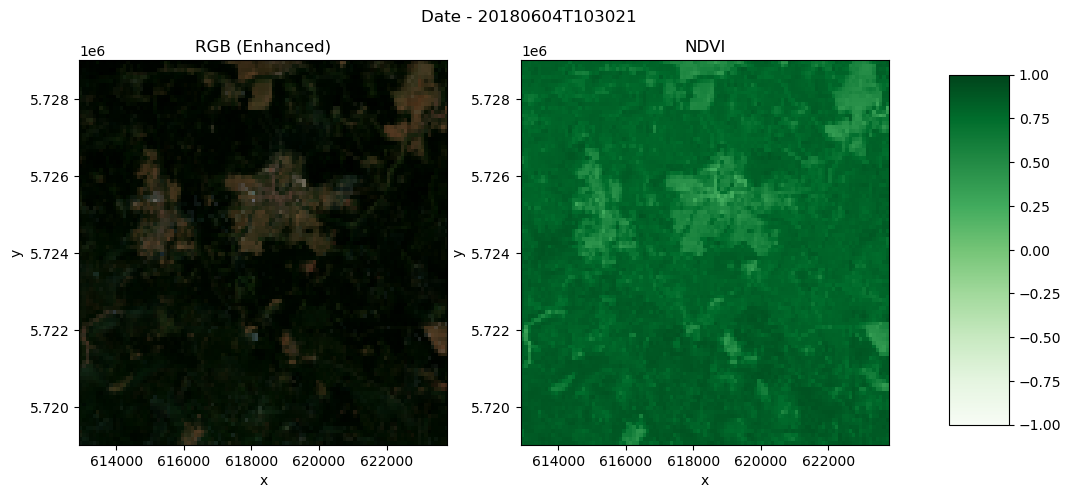

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Date - 20180604T103021\n")

# First subplot
rgb.plot.imshow(
    ax=ax1,
    rgb="bands",
    extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
)

ax1.set_title("RGB (Enhanced)")

# Second plot
ndvi_plot = ndvi.plot(ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False)
ax2.set_title("NDVI")

# Add color bar on the right
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ndvi_plot, cax=cbar_ax)

###  Yearly mean 

In [28]:
# Group by year and compute mean
yearly_ds = (
    reflectances_r100m.sel(x=x_slice, y=y_slice)
    .groupby("time.year")
    .mean(dim="time", skipna=True)
)
yearly_ds

<xarray.Dataset> Size: 3MB
Dimensions:  (year: 6, y: 100, x: 109)
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
Data variables:
    b02      (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    b03      (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    b04      (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    b08      (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    ndvi     (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>

### Visualize NDVI for 2018

In [29]:
def plot_rgb_ndvi(dset, year, x_slice, y_slice):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Date - " + str(year) + "\n")

    # First subplot
    rgb = dset[["b04", "b03", "b02"]].to_dataarray(dim="bands")
    rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
    rgb = rgb.clip(0, 1)  # Clip to valid range
    rgb.plot.imshow(
        ax=ax1,
        rgb="bands",
        extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
    )
    ax1.set_title("RGB (Enhanced)")

    # Second plot
    ndvi_plot = dset["ndvi"].plot(
        ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False
    )
    ax2.set_title("NDVI")

    # Add color bar on the right
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(ndvi_plot, cax=cbar_ax)

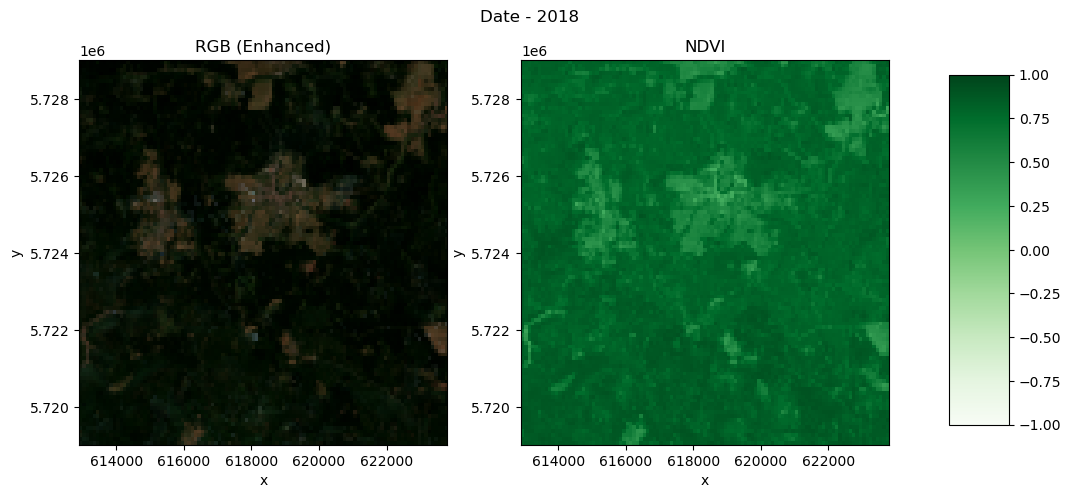

In [30]:
year = 2018
region = yearly_ds.sel(year=year, x=x_slice, y=y_slice)

plot_rgb_ndvi(region, year, x_slice, y_slice)

### Visualise NDVI from 2018 to 2023

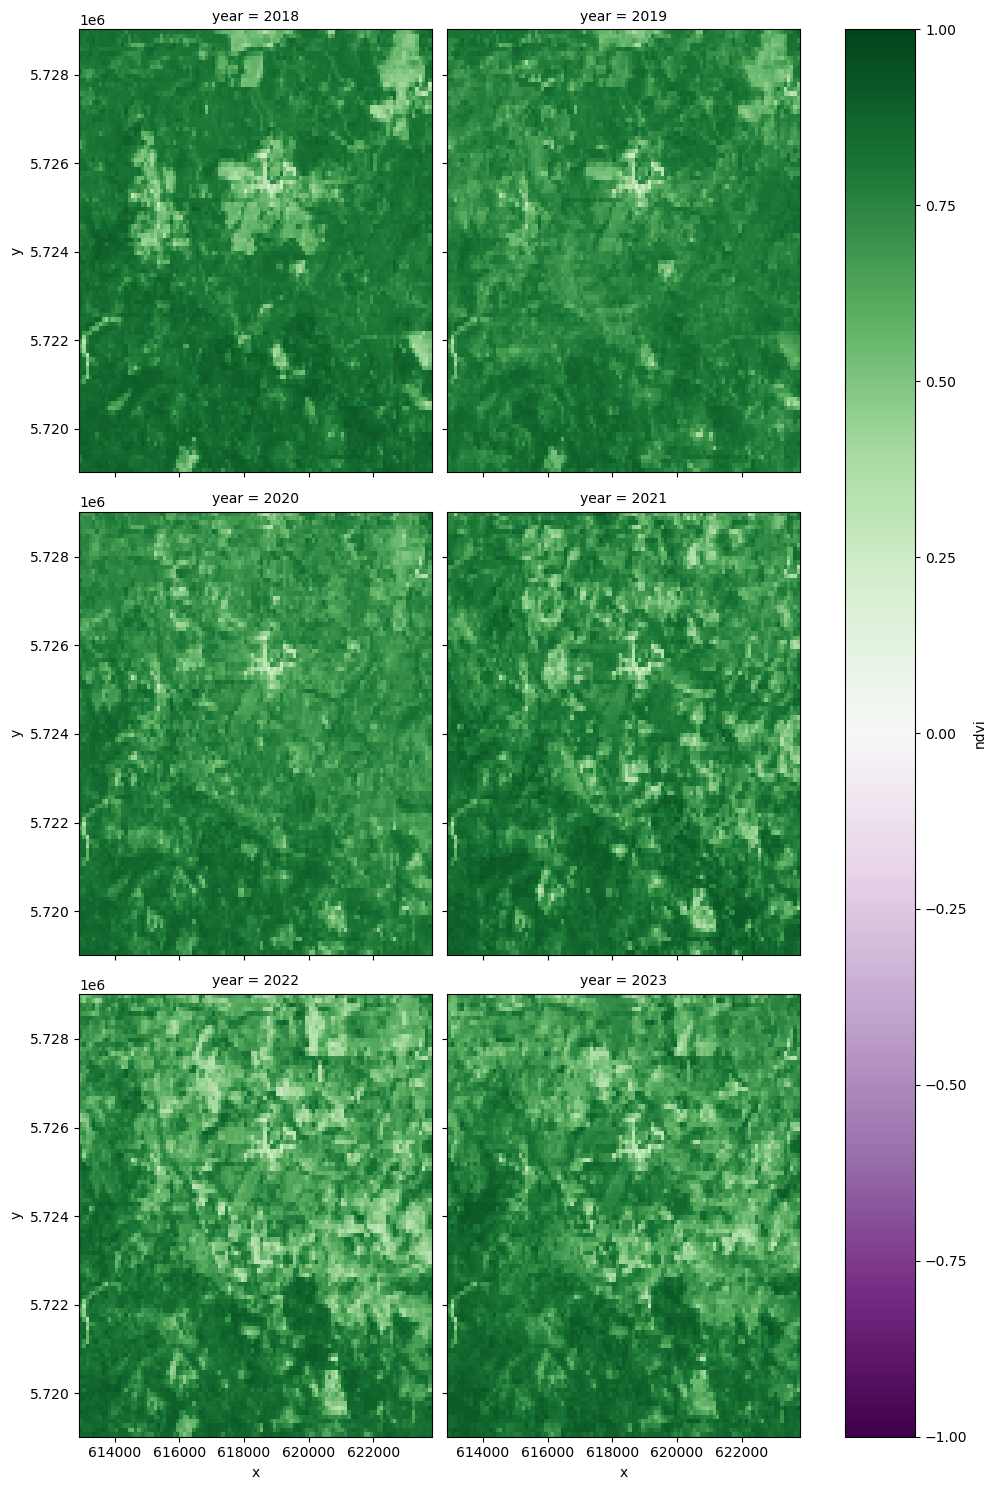

In [31]:
# Select NDVI and plot per year (smaller region for speed)
ndvi_yearly = yearly_ds["ndvi"].sel(x=x_slice, y=y_slice).sel(year=slice(2018, 2023))

ndvi_yearly.plot(
    cmap="PRGn", x="x", y="y", col="year", col_wrap=2, vmin=-1, vmax=1, figsize=(10, 15)
)

### Saving yearly NDVI into local Zarr

Prepare the dataset to be saved with a particular attention to chunks

In [32]:
region = region.chunk({"y": 50, "x": 55})
print(region.chunks)

Frozen({'y': (50, 50), 'x': (55, 54)})


In [33]:
%%time
from zarr.codecs import BloscCodec

compressor = BloscCodec(cname="zstd", clevel=3, shuffle="bitshuffle", blocksize=0)

encoding = {}

for var in region.data_vars:
    encoding[var] = {"compressors": [compressor]}
for coord in region.coords:
    encoding[coord] = {"compressors": [compressor]}
region.to_zarr("ndvi_region.zarr", zarr_format=3, encoding=encoding, mode="w")

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


CPU times: user 3.85 s, sys: 262 ms, total: 4.11 s
Wall time: 14.3 s


(Analysis_DEF)=
## Analysis


For analysis the first step is to classify pixels as forest. In our case we will just do a simple thresholding classification where we classify everything above a certain threshold as forest. This isn't the best approach for classifying forest, since agricultural areas can also easily reach very high NDVI values. A better approach would be to classify based on the temporal signature of the pixel. 

However, for this basic analysis, we stick to the simple thresholding approach.

In this case we classify everything above an NDVI of 0.7 as forest. This calculated forest mask is then saved to a new Data Variable in the xarray dataset: 

In [35]:
yearly_ds["FOREST"] = yearly_ds.ndvi > 0.7

With this forest mask we can already do a quick preliminary analysis to plot the total forest area over the years.

To do this we sum up the pixels along the x and y coordinate but not along the time coordinate. This will leave us with one value per year representing the number of pixels classified as forest. We can then calculate the forest area by multiplying the number of forest pixels by the resolution.

In [36]:
def to_km2(dataarray, resolution):
    # Calculate forest area
    return dataarray * np.prod(list(resolution)) / 1e6

In [37]:
resolution = (100, 100)
forest_pixels = yearly_ds.sel(x=x_slice, y=y_slice).FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
dask.array<truediv, shape=(6,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

In [38]:
forest_area_km2.load()

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
array([92.  , 88.07, 75.26, 79.14, 57.38, 69.15])
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

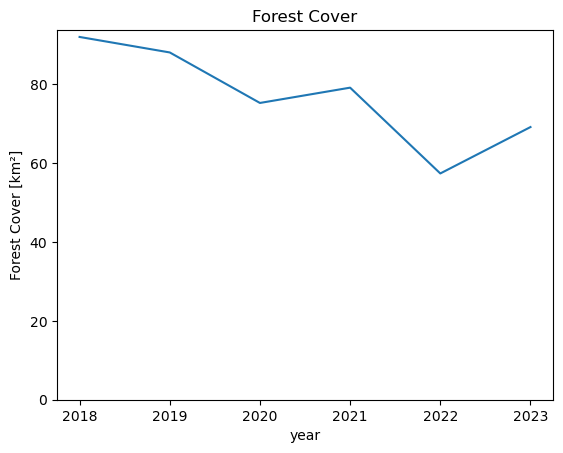

In [39]:
forest_area_km2.plot()

plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0);

We can see that the total forest area in this AOI decreased from around 80 km² in 2018 to only around 50 km² in 2023.

The next step is to make change maps from year to year. To do this we basically take the difference of the forest mask of a year with its previous year.

This will result in 0 value where there has been no change, -1 where forest was lost and +1 where forest was gained.

In [40]:
# Make change maps of forest loss and forest gain compared to previous year

# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and normalize it
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)  # Adjust the range based on your data

### Use 2022 as plot_year

In [41]:
plot_year = 2022
yearly_ds["CHANGE"] = yearly_ds.FOREST.astype(int).diff("year", label="upper")

In [42]:
yearly_ds["CHANGE"].compute()

<xarray.DataArray 'CHANGE' (year: 6, y: 100, x: 109)> Size: 523kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0., -1., -1., ...,  0.,  0.,  0.],
        [-1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[-1., -1.,  0., ...,  0.,  0.,  0.],
        [-1., -1., -1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [-1., -1., -1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], shape=(6, 100, 109))
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

### Visualize the differences

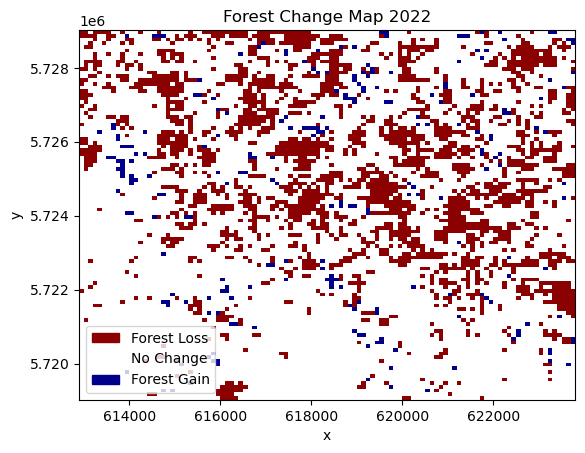

In [43]:
yearly_ds.CHANGE.sel(year=plot_year).plot(cmap=cmap, norm=norm, add_colorbar=False)
# Create a legend with string labels
legend_patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {plot_year}");

Here, we can see the spatial distribution of areas affected by forest loss. In the displayed change from 2021 to 2022, most of the forest loss happened in the northern part of the study area, while the southern part lost comparatively less forest.

To get a feel for the loss per year, we can cumulatively sum up the lost areas over the years. This should basically follow the same trends as the earlier plot of total forest area. 

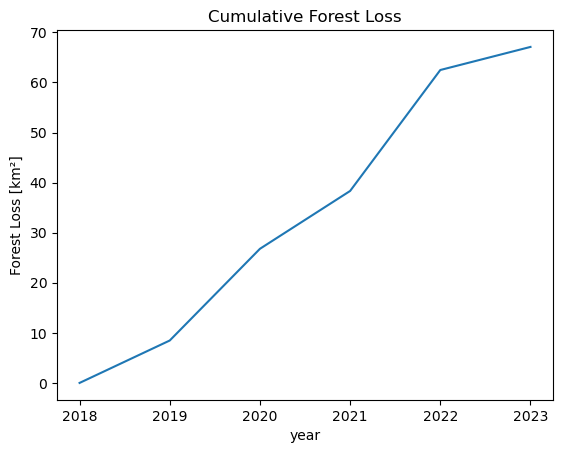

In [44]:
# Forest Loss per Year
forest_loss = (yearly_ds.CHANGE == -1).sum(["x", "y"])
forest_loss_km2 = to_km2(forest_loss, resolution)
forest_loss_km2.cumsum().plot()
plt.title("Cumulative Forest Loss")
plt.ylabel("Forest Loss [km²]");

We can see that there have been two years with particularly large amounts of lost forest area. From 2019-2020 and with by far the most lost area between 2021 and 2022.

(Validation_DEF)=
## Validation


Finally, we want to see how accurate our data is compared to the widely used Hansen Global Forest Change data. In a real scientific scenario, we would use Ground Truth data to assess the accuracy of our classification. In this case we use the Global Forest Change data in place of Ground Truth data, just to show how an accuracy assessment can be done. The assessment we are doing only shows how accurately we replicate the Global Forest Change data, however we will not know if our product is more or less accurate. For a more accurate assessment, actual Ground Truth data is required.

First we download the Global Forest Change Data [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html) and open it using Xarray.

In [45]:
data_path = Path("./data/")
data_path.mkdir(parents=True, exist_ok=True)
hansen_filename = "Hansen_GFC-2022-v1.10_lossyear_60N_010E.tif"
comp_data = data_path / hansen_filename

with comp_data.open("wb") as fs:
    hansen_data = requests.get(
        f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/{hansen_filename}"
    )
    fs.write(hansen_data.content)

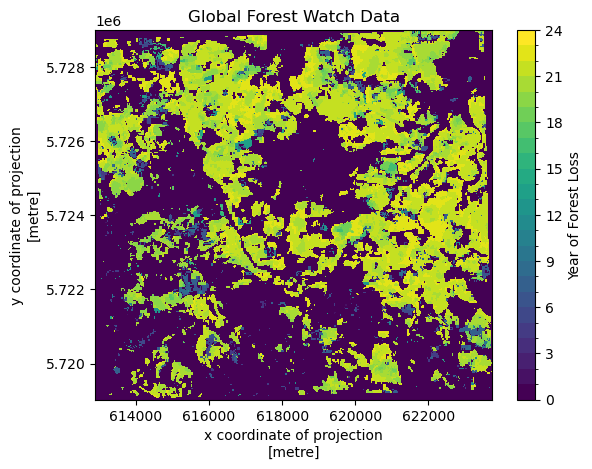

In [46]:
import matplotlib.pyplot as plt
import rioxarray

target_epsg = epsg

# Open the file (replace 'comp_data' with your raster file path)
ground_truth = (
    rioxarray.open_rasterio(comp_data)  # Replace with your file path
    .rio.clip_box(
        minx=bbox[0],
        miny=bbox[1],
        maxx=bbox[2],
        maxy=bbox[3],
    )
    .rio.reproject(target_epsg)
    .sel(band=1)
    .where(lambda gt: gt < 100, 0)  # Fill no-data (values > 100) with 0
)

# Plot
ground_truth.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch Data")
plt.show()

The data shows in which year forest was first lost. To compare with our own data, we need to add the data to our dataset. To do this the data needs to have the same coordinates. This can be achieved with `.interp_like()`. This function interpolates the data to match up the coordinates of another dataset.

In this case we chose the interpolation method `nearest` since it is categorical data.

In [47]:
yearly_ds["GROUND_TRUTH"] = ground_truth.interp_like(
    yearly_ds, method="nearest"
).astype(int)
yearly_ds

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.Dataset> Size: 3MB
Dimensions:       (x: 109, y: 100, year: 6)
Coordinates:
  * x             (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y             (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * year          (year) int64 48B 2018 2019 2020 2021 2022 2023
    band          int64 8B 1
    spatial_ref   int64 8B 0
Data variables:
    b02           (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    b03           (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    b04           (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    b08           (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    ndvi          (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    FOREST        (year, y, x) bool 65kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    CHANGE        (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    GROUND_TRUTH  (y, x) int64 87kB 0 0 0 0 0 0 ... 0 0 0 0 -9223372036854775808

The ground truth data saves the year when deforestation was first detected for a pixel in a single raster. To do this, it encodes the year of forest loss as an integer, giving the year. So, an integer 21 means the pixel was first detected as deforested in 2021, whereas a value of 0 means that deforestation was never detected.

Currently our classification saves the deforestation detection in multiple rasters, one for each year. To get our data into a format that is similar to our comparison data we need to convert our rasters for each time step into a single one.

To do this we first assign all pixels which were detected as deforestation (`CHANGE == -1`) to the year in which the deforestation was detected (`lost_year`). Then we compute over our time-series the first occurence of deforestation (equivalent to the first non-zero value) per pixel. This is then saved in a new data variable.

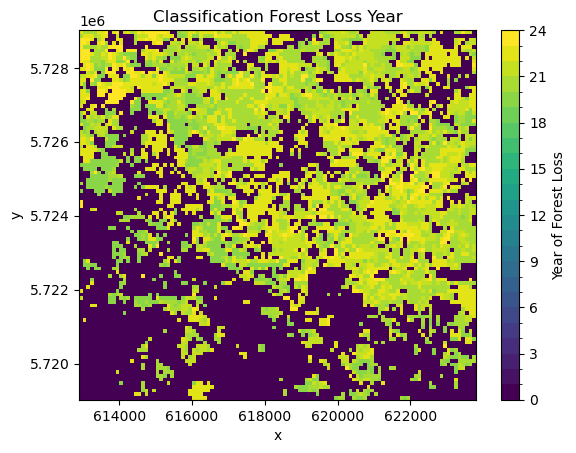

In [48]:
# convert lost forest (-1) into the year it was lost
lost_year = (yearly_ds.CHANGE == -1) * yearly_ds.year % 100
first_nonzero = (lost_year != 0).argmax(axis=0).compute()
yearly_ds["LOST_YEAR"] = lost_year[first_nonzero]
yearly_ds.LOST_YEAR.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Classification Forest Loss Year");

Comparing this visually to the Global Forest Watch data, allows us to do some initial quality assessment. We can see definite differences between the two datasets. The Global Forest Watch data has much more clearly defined borders. In general, our classification seems to overestimate deforestation. However, the general pattern of forest loss is the same in both. Most of the deforestation is in the north of the study area, with less forest loss in the south.

There are a few reasons for those differences. The main difference has to be in our much more simple approach to forest classification and change detection. It is expected that our approach will lead to large amounts of commission errors since changes are only confirmed using a single observation. It however can also lead to a lot of omission errors since the NDVI thresholding might classify highly productive non-forest areas as forest due to their high NDVI values. 

However, there are also some systematic differences. Our algorithm looks at differences between the middle of the years, which means that some changes can happen at the end of the growing year which will be detected first in the next year whereas the Global Forest Watch dataset will detect it in the correct (earlier) year.

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


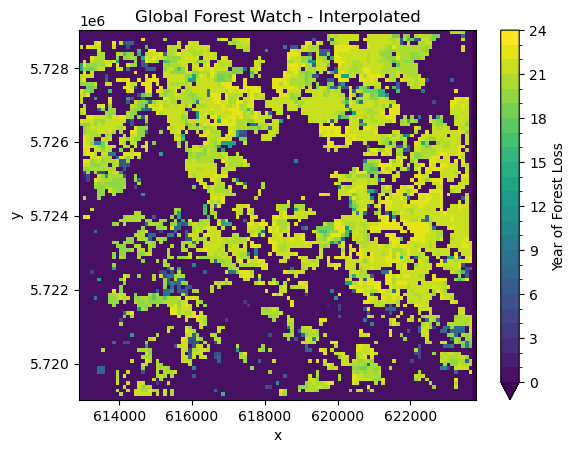

In [49]:
yearly_ds.GROUND_TRUTH.plot(
    levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"}, cmap="viridis"
)
plt.title("Global Forest Watch - Interpolated");

Finally, we can also calculate an accuracy score. This is a score from 0-1, where values close to 0.5 basically mean that the classification is random, and values close to 1 mean that most of the values of our comparison data and classification data match.

First, we look at the overall accuracy of forest loss over the entire period from 2018 to 2023.

In [50]:
from sklearn.metrics import accuracy_score

score = accuracy_score(
    (yearly_ds.LOST_YEAR > 18).values.ravel(),
    (yearly_ds.GROUND_TRUTH > 18).values.ravel(),
)
print(f"The overall accuracy of forest loss detection is {score:.2f}.")

The overall accuracy of forest loss detection is 0.76.


As expected from the visual interpretation, with an accuracy of 0.76, our product differs quite a lot compared to the Global Forest Watch data. From this we do not know for sure that our product is less accurate compared to the actual forest loss patterns observed on the ground. We only know that it is different to the Global Forest Watch product. It might be more or less accurate. 

However, because of the simplicity of our algorithm, it is safe to assume that our output is less accurate. 

(Summary_DEF)=
## Summary


This notebook demonstrated how to efficiently access and analyze Sentinel-2 data stored in the EOPF Zarr format using Xarray and the EOPF Sample Service JupyterHub environment. It included steps for generating cloud-free mosaics and calculating spectral indices directly in the cloud.

We also showed how to load this data using Xarray and perform a basic multi-temporal detection of forest loss.

This notebook is intended as a starting point for your own analyses using the powerful Python data science ecosystem, supported by the scalable and analysis-ready data infrastructure provided by EOPF. Further examples will show how to access sentinel 2 data via STAC (Spatio-Temporal Asset Catalog).

In [51]:
client.close()

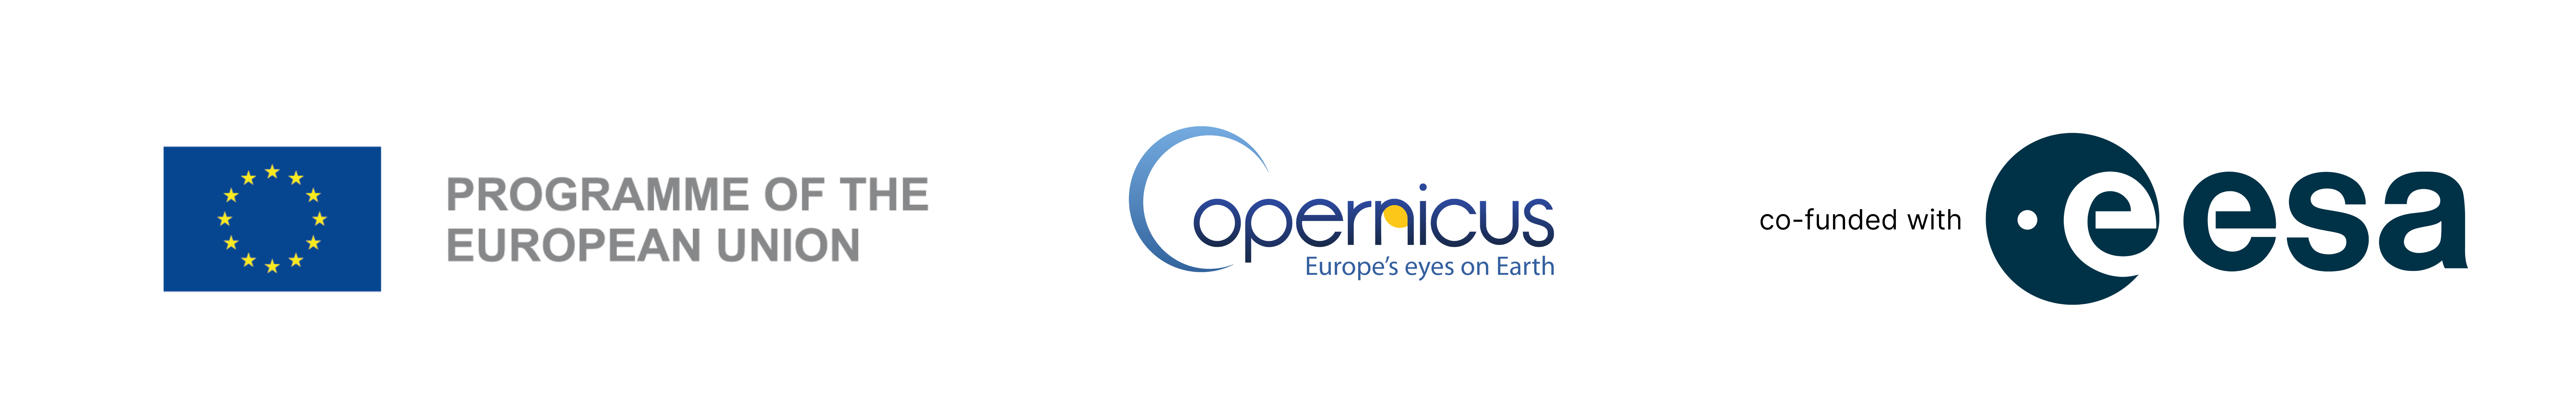